In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import numpy as np
from skimage.util import random_noise
import cv2
from torchvision.transforms import ToTensor


Add noise, using skimage's random_noise function

In [10]:
import os
from torchvision.datasets import ImageFolder
import numpy as np
from skimage.util import random_noise
import torch
from torch.utils.data import Dataset

class NoisyImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.dataset = ImageFolder(root_dir, transform=transform)
        self.transform = transform

    def add_noise(self, image):
        noise_type = np.random.choice(['gaussian', 'salt', 'pepper', 'speckle'])
        if noise_type == 'gaussian':
            noisy_img = random_noise(image, mode='gaussian', var=0.01)
        elif noise_type == 'salt':
            noisy_img = random_noise(image, mode='salt', amount=0.02)
        elif noise_type == 'pepper':
            noisy_img = random_noise(image, mode='pepper', amount=0.02)
        elif noise_type == 'speckle':
            noisy_img = random_noise(image, mode='speckle', var=0.01)
        return np.clip(noisy_img, 0, 1)

    def __getitem__(self, index):
        path, _ = self.dataset.samples[index]
        filename = os.path.basename(path)
        clean_img, _ = self.dataset[index]
        noisy_img = self.add_noise(clean_img.numpy().transpose(1, 2, 0))
        noisy_img = torch.tensor(noisy_img.transpose(2, 0, 1)).float()
        return noisy_img, clean_img, filename

    def __len__(self):
        return len(self.dataset)

Define denoising model

In [11]:
class SkipDenoisingModel(nn.Module):
    def __init__(self):
        super(SkipDenoisingModel, self).__init__()
        
        self.encoder1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
    )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.encoder4 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.pool = nn.MaxPool2d(2, 2)
        
        self.decoder4 = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2),
            nn.ReLU(),
        )
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2),
            nn.ReLU(),
        )
        
        self.final = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        # encode
        x = self.encoder1(x)
        x = self.pool(x)
        enc2 = self.encoder2(x)
        x = self.pool(enc2)
        enc3 = self.encoder3(x)
        x = self.pool(enc3)
        enc4 = self.encoder4(x) 

        x = self.pool(enc4)
        # decode
        x = self.decoder4(x)
        x = enc4 + x                                                        
        x = self.decoder3(x)
        x = enc3 + x
        x = self.decoder2(x)
        x = enc2 + x
        x = self.decoder1(x)
        x = self.final(x)
        return x

Visualization Function

In [16]:
import matplotlib.pyplot as plt

def visualize_results(original, noisy, denoised, index=0, filename=None):
    """
    Visualize the original, noisy, and denoised images side by side.
    Optionally, display the filename.
    """
    original_img = original[index].detach().cpu().permute(1, 2, 0).numpy()
    noisy_img = noisy[index].detach().cpu().permute(1, 2, 0).numpy()
    denoised_img = denoised[index].detach().cpu().permute(1, 2, 0).numpy()

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f"Image: {filename if filename else 'N/A'}", fontsize=16)

    axs[0].imshow(original_img)
    axs[0].set_title('Original')
    axs[0].axis('off')

    axs[1].imshow(noisy_img)
    axs[1].set_title('Noisy')
    axs[1].axis('off')

    axs[2].imshow(denoised_img)
    axs[2].set_title('Denoised')
    axs[2].axis('off')

    plt.show()


Train model function, visualize every 500 batches

In [22]:
def train_model(model, dataloader, num_epochs=20):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for i, (noisy_imgs, clean_imgs, filenames) in enumerate(dataloader):
            noisy_imgs, clean_imgs = noisy_imgs.to("mps"), clean_imgs.to("mps")
            
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Visualize every 500 batches
            if i % 500 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(dataloader)}], Loss: {loss.item():.4f}")
                visualize_results(clean_imgs, noisy_imgs, outputs.detach(), index=0, filename=filenames[0])

        print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {running_loss/len(dataloader):.4f}")
    
    print("Training complete")
    return model


Evaluate Model function

In [23]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

def evaluate_model(model, dataloader, device='cpu'):
    """
    Evaluate the model on a given dataloader and compute PSNR and SSIM metrics.
    """
    model.eval()
    psnr_total = 0
    ssim_total = 0
    num_batches = 0

    with torch.no_grad():
        for noisy_imgs, clean_imgs, filenames in dataloader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            
            outputs = model(noisy_imgs)
            
            batch_psnr = 0
            batch_ssim = 0

            # Compute PSNR and SSIM for each image in the batch
            for i in range(len(noisy_imgs)):
                psnr = peak_signal_noise_ratio(
                    clean_imgs[i].cpu().numpy(),
                    outputs[i].cpu().numpy(),
                    data_range=1.0 
                )
                ssim = structural_similarity(
                    clean_imgs[i].cpu().numpy().transpose(1, 2, 0),
                    outputs[i].cpu().numpy().transpose(1, 2, 0),
                    win_size=7,
                    channel_axis=-1,
                    data_range=1.0
                )
                
                batch_psnr += psnr
                batch_ssim += ssim
                print(f"Filename: {filenames[i]}, PSNR: {psnr:.4f}, SSIM: {ssim:.4f}")
            
            psnr_total += batch_psnr / len(noisy_imgs)
            ssim_total += batch_ssim / len(noisy_imgs)
            num_batches += 1

            break

    avg_psnr = psnr_total / num_batches
    avg_ssim = ssim_total / num_batches
    print(f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}")

    return avg_psnr, avg_ssim


Train model

mps
Epoch [1/10], Step [0/230], Loss: 0.1138


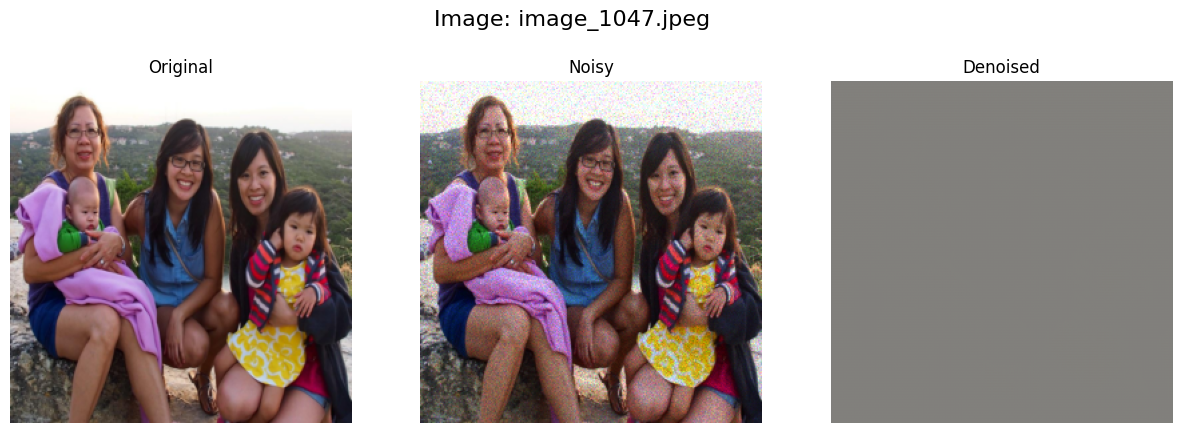

Epoch [1/10] completed. Average Loss: 0.0111
Epoch [2/10], Step [0/230], Loss: 0.0042


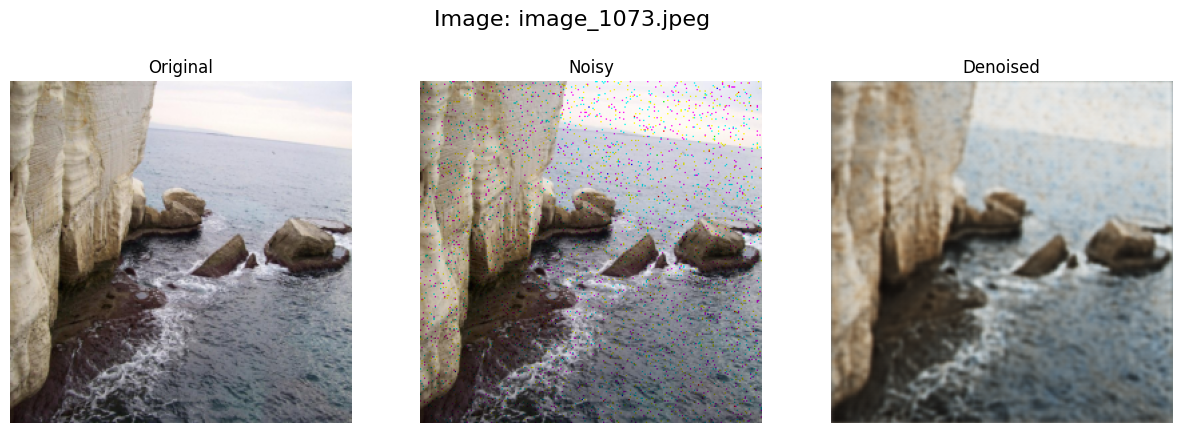

Epoch [2/10] completed. Average Loss: 0.0033
Epoch [3/10], Step [0/230], Loss: 0.0032


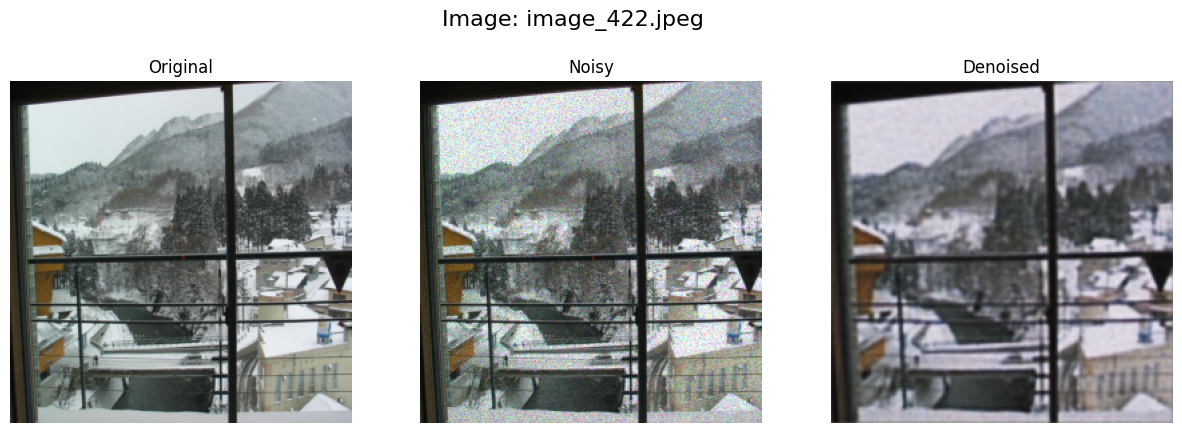

Epoch [3/10] completed. Average Loss: 0.0024
Epoch [4/10], Step [0/230], Loss: 0.0029


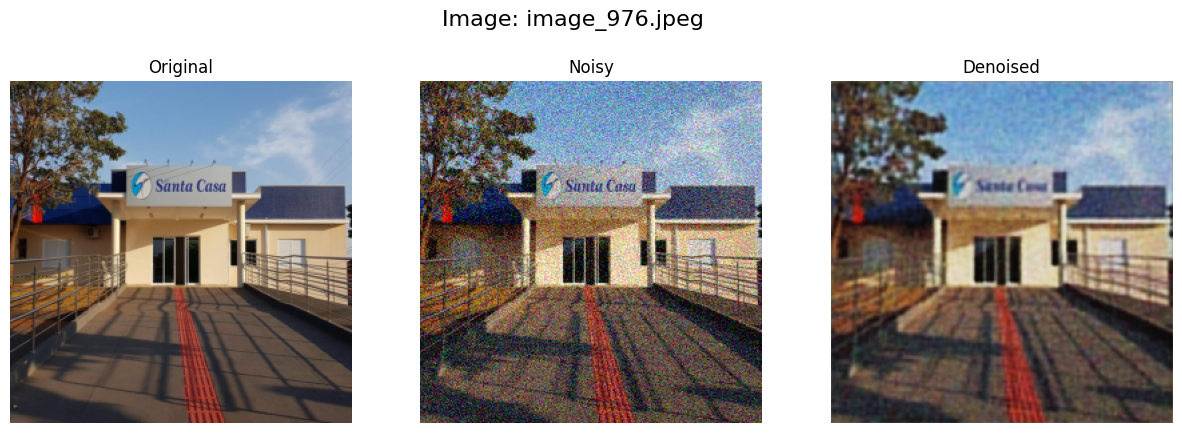

Epoch [4/10] completed. Average Loss: 0.0020
Epoch [5/10], Step [0/230], Loss: 0.0026


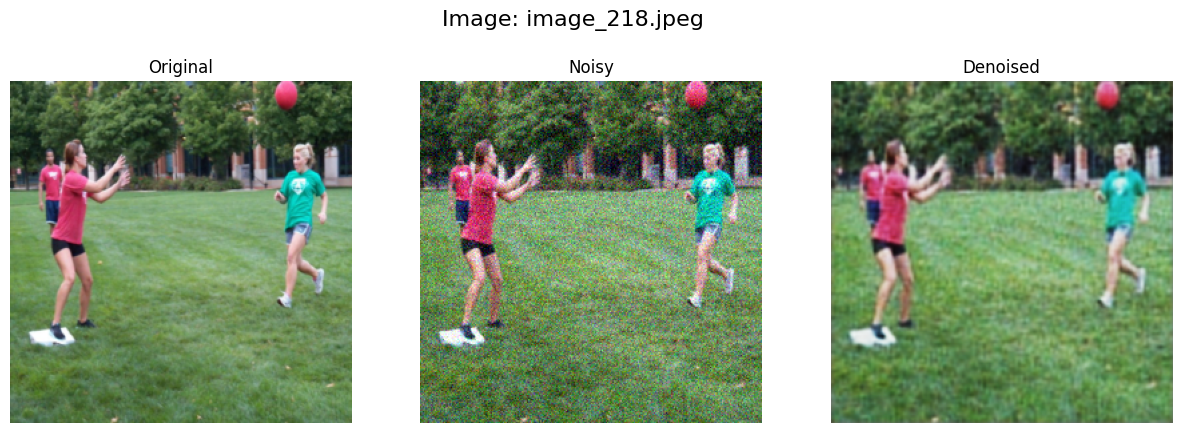

Epoch [5/10] completed. Average Loss: 0.0019
Epoch [6/10], Step [0/230], Loss: 0.0015


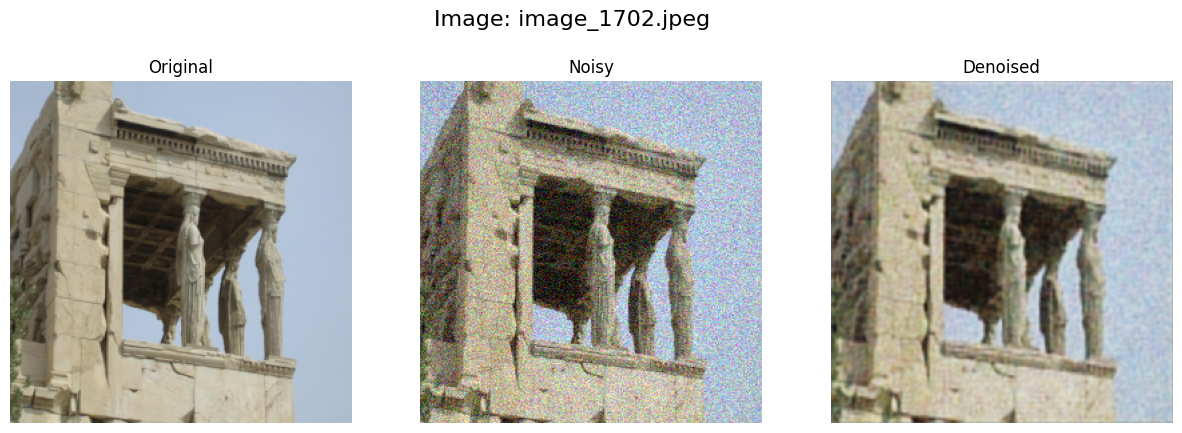

Epoch [6/10] completed. Average Loss: 0.0017
Epoch [7/10], Step [0/230], Loss: 0.0016


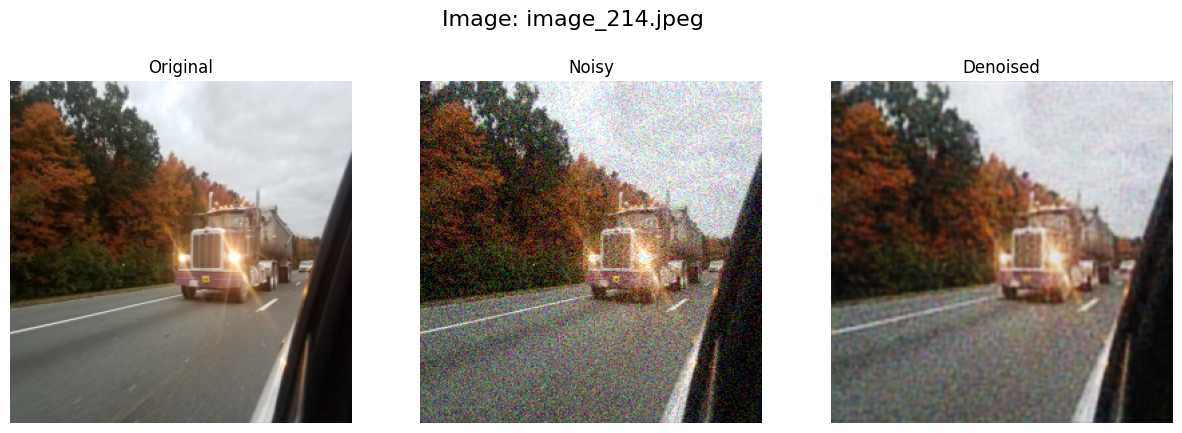

Epoch [7/10] completed. Average Loss: 0.0016
Epoch [8/10], Step [0/230], Loss: 0.0015


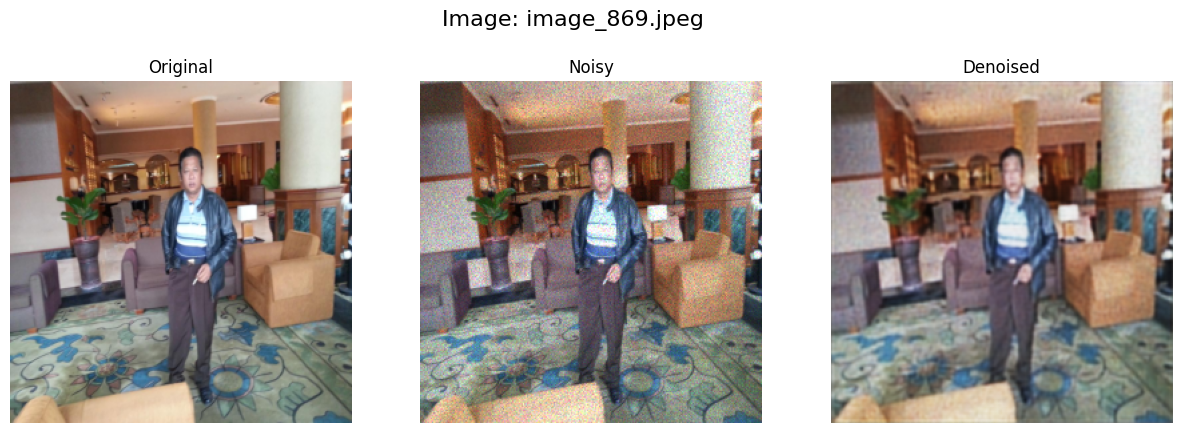

Epoch [8/10] completed. Average Loss: 0.0015
Epoch [9/10], Step [0/230], Loss: 0.0015


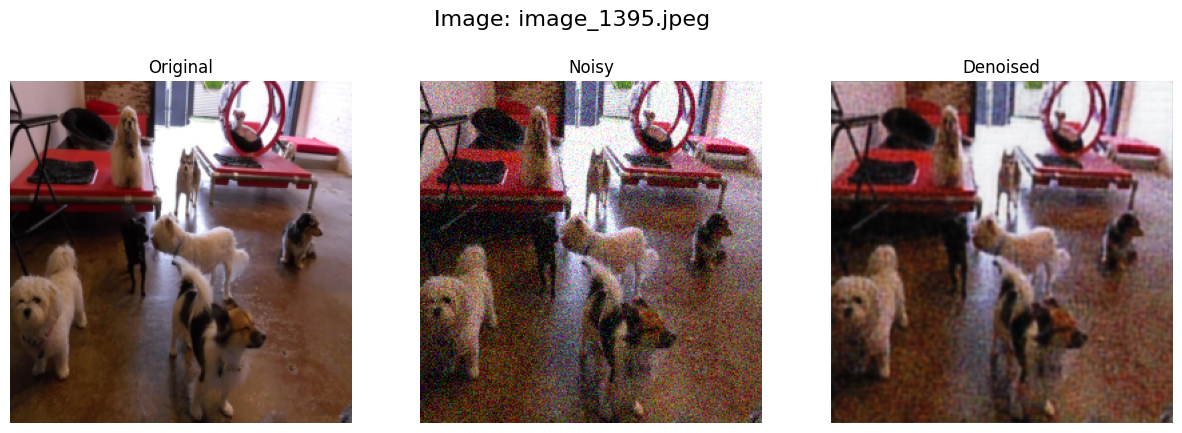

Epoch [9/10] completed. Average Loss: 0.0014
Epoch [10/10], Step [0/230], Loss: 0.0011


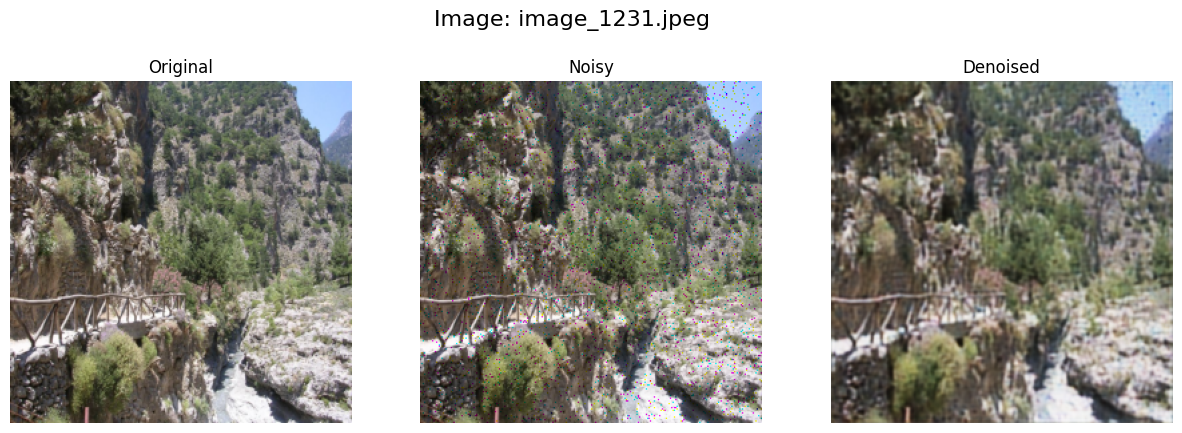

Epoch [10/10] completed. Average Loss: 0.0014
Training complete


In [24]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = NoisyImageDataset(root_dir='Deep-Learning-Data', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)

model = SkipDenoisingModel().to("mps")
trained_model = train_model(model, dataloader, num_epochs=10) 

Evaluate Model

In [25]:
evaluate_model(trained_model, dataloader, device)

Filename: image_393.jpeg, PSNR: 29.3381, SSIM: 0.7726
Filename: image_771.jpeg, PSNR: 25.4872, SSIM: 0.7959
Filename: image_1812.jpeg, PSNR: 26.8499, SSIM: 0.8718
Filename: image_310.jpeg, PSNR: 29.9348, SSIM: 0.8152
Filename: image_966.jpeg, PSNR: 33.3564, SSIM: 0.7832
Filename: image_1026.jpeg, PSNR: 29.8006, SSIM: 0.8392
Filename: image_89.jpeg, PSNR: 31.7804, SSIM: 0.8350
Filename: image_1755.jpeg, PSNR: 29.6962, SSIM: 0.8689
Average PSNR: 29.5305, Average SSIM: 0.8227


(np.float64(29.530459347471357), np.float32(0.8227284))